Deep Neural Network

In [32]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
# from utils.helper import fn_plot_tf_hist

In [2]:
def fn_plot_tf_hist(hist_df):

    '''
    Args:
        hist_df: a dataframe with following ccolumns
            column 0: accuracy
            column 1: loss
            column 2: val_accuracy
            column 3: val_loss
            While plotting columns are accessed by index
            so that even if the column names are different it will not throw exceptions.
    '''

    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)
    facecolor = 'cyan'
    fontsize=12
    CMAP = plt.cm.coolwarm

    # Get columns by index to eliminate any column naming error
    y1 = hist_df.columns[0]
    y2 = hist_df.columns[1]
    y3 = hist_df.columns[2]
    y4 = hist_df.columns[3]

    # Where was min loss
    best = hist_df[hist_df[y4] == hist_df[y4].min()]

    ax = axes[0]

    hist_df.plot(y = [y2,y4], ax = ax, colormap=CMAP)


    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n   test: {:6.4f}'
    txtstr = txtFmt.format(y2.capitalize(),
                           hist_df.iloc[-1][y2],
                           hist_df.iloc[-1][y4]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y2].min(), hist_df[y4].min())
    y_max = max(hist_df[y2].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y4].to_numpy()[0] + offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel('Epochs')
    ax.set_ylabel(y2.capitalize())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    ax = axes[1]

    hist_df.plot( y = [y1, y3], ax = ax, colormap=CMAP)

    # little beautification
    txtFmt = '{:s}: \n  train: {:6.4f}\n  test:  {:6.4f}'
    txtstr = txtFmt.format(y1.capitalize(),
                           hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y3]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=fontsize,
            verticalalignment='top', bbox=props)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y3].min())
    y_max = max(hist_df[y1].max(), hist_df[y3].max())
    offset = (y_max-y_min)/10.0

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y3].to_numpy()[0]:6.4f}', # text to print
                xy=(best.index.to_numpy(), best[y3].to_numpy()[0]), # Arrow start
                xytext=(best.index.to_numpy(), best[y3].to_numpy()[0]-offset), # location of text
                fontsize=fontsize, va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor=facecolor, shrink=0.05)) # arrow


    # Draw vertical line at best value
    ax.axvline(x = best.index.to_numpy(), color = 'green', linestyle='-.', lw = 3)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [3]:
### ----------------------
### global variables
### ----------------------

import random

RANDOM_STATE = 24
tf.random.set_seed(RANDOM_STATE)


TEST_SIZE = 3811
ALPHA = 0.001 # LEARNING RATE
EPOCHS = 100  # NUMBER OF ITERATIONS
BATCH_SIZE = 256

# input and output directories
inpDir = '../../input'
outDir = '../output'

params = {
    'legend.fontsize': 'medium',
    'figure.figsize': (10, 6),
    'axes.labelsize': 'medium',
    'axes.titlesize':'large',
    'xtick.labelsize':'medium',
    'ytick.labelsize':'medium'
}

plt.rcParams.update(params)

CMAP = plt.cm.coolwarm
plt.style.use('seaborn-v0_8-darkgrid')

# Load Data

# EDA
1. Remove Null from Position
2. Read unique values from the columns

In [4]:
data_df = pd.read_csv("fashion-mnist_train.csv")
data_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
x_train_cols = data_df.drop(["label"], axis = 1)
y_train_cols = data_df["label"].to_numpy()
x_train_cols.shape, y_train_cols.shape

((60000, 784), (60000,))

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x_train_cols,
                                                    y_train_cols,
                                                    test_size = 0.2,
                                                    random_state = 24,
                                                    stratify = y_train_cols)

In [7]:
test_df = pd.read_csv("fashion-mnist_test.csv")
x_valid = test_df.drop("label", axis = 1).to_numpy()
y_valid = test_df["label"].to_numpy()

x_train.shape, x_test.shape, x_valid.shape, y_train.shape, y_test.shape, y_valid.shape

((48000, 784), (12000, 784), (10000, 784), (48000,), (12000,), (10000,))

In [8]:
# Nromalize the data between [0, 1]

x_train = x_train / 255.0

x_test = x_test / 255.0

x_valid = x_valid / 255.0

In [9]:
class_names = {0 : "T-shirt",
               1 : "Trousers",
               2 : "long sleeves",
               3 : "dress",
               4 : "hoodie",
               5 : "sandle",
               6 : "shirt",
               7 : "sneaker",
               8 : "bag",
               9 : "boot"}

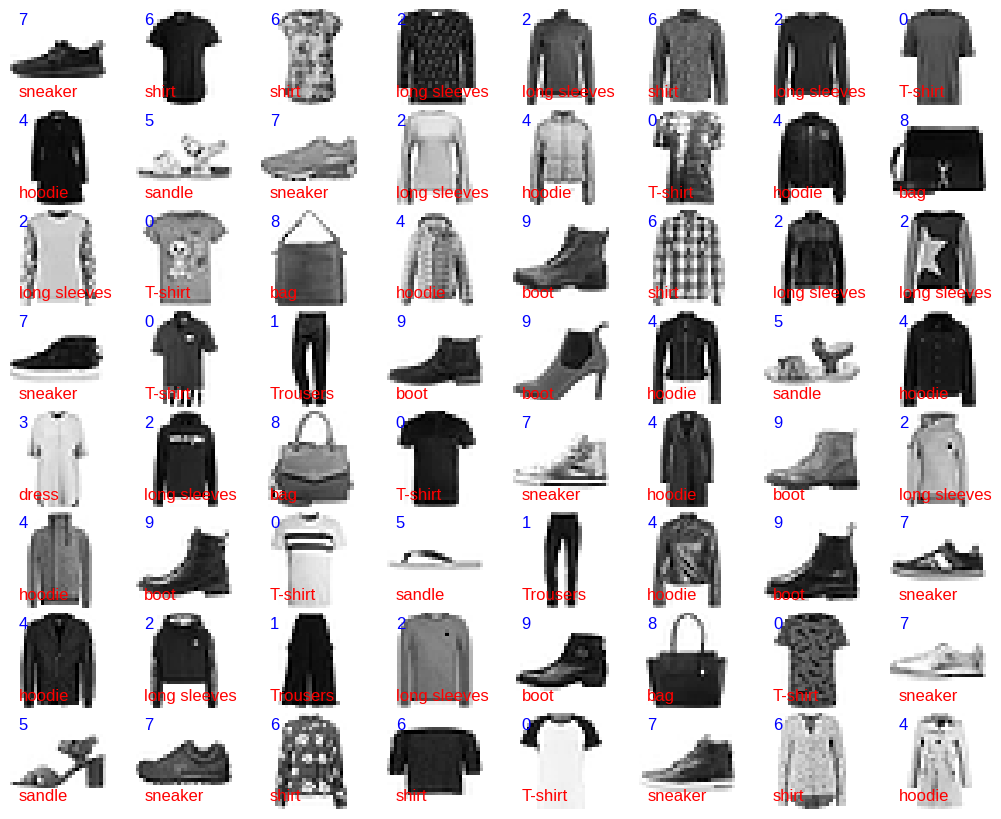

In [10]:
n_rows = 8 # Number of rows in grid
n_cols = 8 # Number of columns in grid

# Randomly sample n_rows * n_cols images from dataset
plot_df= data_df.sample(n = n_rows *  n_cols)

# create new figure with larger grid
fig = plt.figure(figsize = (10, 8))

# adjust spacing between subplots to eliminate gaps
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

# subplot index
i = 0

# Iterate on each row
for idx, row in plot_df.iterrows():
    i += 1  # Increment subplot index.

    # reshape the row values (excluding the first column) into a 28 x 28 matrix
    image = row.values[1:].reshape(28, 28)

    # add a subplot to the figure at the 'i'th position in the grid
    ax = fig.add_subplot(n_rows, n_cols, i, xticks = [], yticks = [])

    # display the image on the subplot using a binary colormap
    ax.imshow(image, cmap = plt.cm.binary, interpolation = "nearest")

    # add the numeric label of the image in blue text at a specific position
    ax.text(2, 4, str(row.iloc[0]), color = "b", fontsize = 12)

    # add the class name of the image in red text below the nmeric label
    ax.text(2, 25, class_names[row.iloc[0]], color = "r", fontsize = 12)

# display the entire grid of images
plt.show()

In [11]:
# Tensor slices

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train))
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test))
valid_ds = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))

In [12]:

train_shape = x_train.shape
test_shape = x_test.shape
valid_shape = x_valid.shape

In [13]:
import gc
del data_df, test_df, x_train_cols, y_train_cols,
gc.collect()
gc.collect()
gc.collect()

0

In [14]:
# shuffle and batch the dataset
# - By chaining these operations (suffle and batch) the dataset is first huffled
# - and then divided into batches, making it ready for training.
train_ds = train_ds.shuffle(buffer_size = train_shape[0]).batch(BATCH_SIZE)

test_ds = test_ds.shuffle(buffer_size = test_shape[0]).batch(BATCH_SIZE)

valid_ds = valid_ds.shuffle(buffer_size = valid_shape[0]).batch(BATCH_SIZE)

In [15]:
## Optimize for performance,
# Cache the data to avoid redundant processing
# Repeat the dataset for multiple epochs
# prefetch data to overlap preprocessing and model execution:

train_ds = train_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)


# Prepare model

### Functional API

In [17]:
inputs = tf.keras.Input(shape = (train_shape[1],), name = "input")

x = tf.keras.layers.Dense(196,
                         activation = tf.keras.activations.relu,
                         name = "fc_1")(inputs)

x = tf.keras.layers.Dense(49,
                          activation = tf.keras.activations.relu,
                          name = "fc_2")(x)

x = tf.keras.layers.Dense(24,
                          activation = tf.keras.activations.relu,
                          name = "fc_3")(x)

outputs = tf.keras.layers.Dense(10, name = "output")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "MNIST")

In [18]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 196)                 │         153,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 49)                  │           9,653 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_3 (Dense)                         │ (None, 24)                  │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,963 (644.39 KB)

 Trainable params: 164,963 (644.39 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics = ["accuracy"])


In [20]:
history = model.fit(train_ds,
                    validation_data = test_ds,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/100
188/188 - 4s - 22ms/step - accuracy: 0.7497 - loss: 0.7322 - val_accuracy: 0.8250 - val_loss: 0.5097
Epoch 2/100
188/188 - 2s - 10ms/step - accuracy: 0.8444 - loss: 0.4472 - val_accuracy: 0.8508 - val_loss: 0.4254
Epoch 3/100
188/188 - 2s - 12ms/step - accuracy: 0.8603 - loss: 0.3959 - val_accuracy: 0.8613 - val_loss: 0.3993
Epoch 4/100
188/188 - 3s - 14ms/step - accuracy: 0.8709 - loss: 0.3649 - val_accuracy: 0.8688 - val_loss: 0.3748
Epoch 5/100
188/188 - 1s - 8ms/step - accuracy: 0.8790 - loss: 0.3414 - val_accuracy: 0.8685 - val_loss: 0.3736
Epoch 6/100
188/188 - 3s - 13ms/step - accuracy: 0.8854 - loss: 0.3222 - val_accuracy: 0.8713 - val_loss: 0.3619
Epoch 7/100
188/188 - 1s - 7ms/step - accuracy: 0.8894 - loss: 0.3072 - val_accuracy: 0.8751 - val_loss: 0.3504
Epoch 8/100
188/188 - 1s - 8ms/step - accuracy: 0.8934 - loss: 0.2952 - val_accuracy: 0.8785 - val_loss: 0.3458
Epoch 9/100
188/188 - 1s - 8ms/step - accuracy: 0.8967 - loss: 0.2857 - val_accuracy: 0.8805 - val_

In [21]:
y_pred = model.predict(x_train)
accuracy_score(y_true = y_train,
               y_pred = y_pred.argmax(axis = 1))

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step


0.9500833333333333

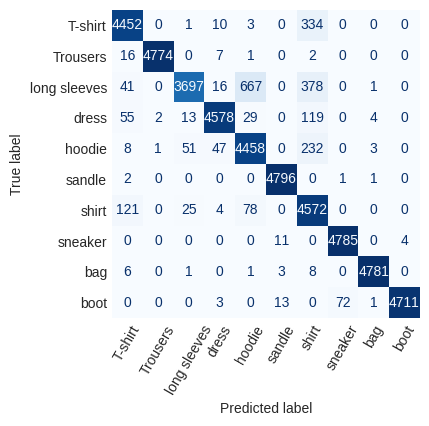

In [22]:
cm = confusion_matrix(y_true = y_train,
                      y_pred = y_pred.argmax(axis = 1))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = class_names.values())
fig, ax = plt.subplots(figsize = (4, 4))
disp.plot(ax = ax, cmap = "Blues", colorbar = False)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 60)
ax.grid(False)

In [23]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,accuracy,loss,val_accuracy,val_loss
0,0.749729,0.732244,0.825000,0.509690
1,0.844354,0.447192,0.850833,0.425359
2,0.860333,0.395920,0.861333,0.399300
3,0.870917,0.364933,0.868833,0.374808
4,0.878979,0.341387,0.868500,0.373645


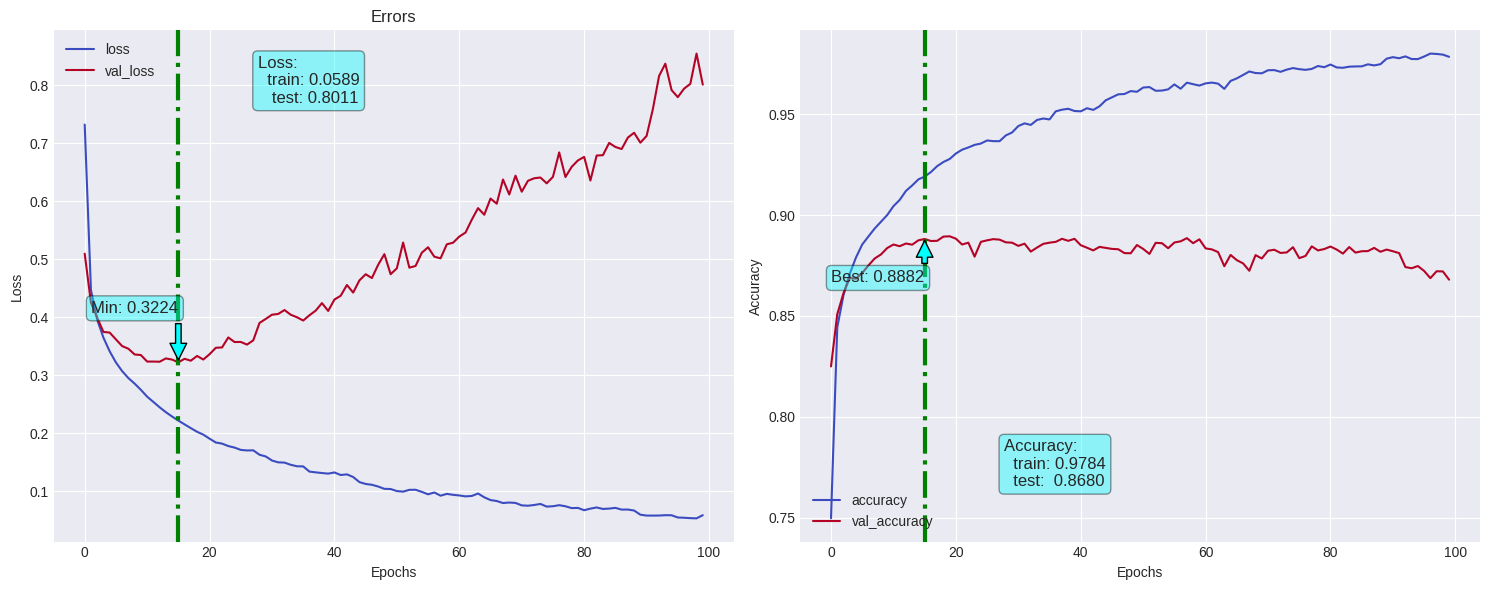

In [24]:
fn_plot_tf_hist(hist_df = hist_df)

L2 Regularization

In [25]:
initializer = tf.keras.initializers.GlorotUniform(seed = RANDOM_STATE)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

# Define rerularizer
regularizer = tf.keras.regularizers.L2(0.05)

inputs = tf.keras.Input(shape = (train_shape[1],), name = "input")

x = tf.keras.layers.Dense(196,
                         activation = tf.keras.activations.relu,
                          kernel_initializer = initializer,
                          kernel_regularizer = regularizer,
                         name = "fc_1")(inputs)

x = tf.keras.layers.Dense(49,
                          activation = tf.keras.activations.relu,
                          kernel_initializer = initializer,
                          kernel_regularizer = regularizer,
                          name = "fc_2")(x)

x = tf.keras.layers.Dense(24,
                          activation = tf.keras.activations.relu,
                          kernel_initializer = initializer,
                          kernel_regularizer = regularizer,
                          name = "fc_3")(x)

outputs = tf.keras.layers.Dense(10, name = "output")(x)

model = tf.keras.Model(inputs = inputs, outputs = outputs, name = "MNIST")

In [26]:
model.summary()

Model: "MNIST"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)                   │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_1 (Dense)                         │ (None, 196)                 │         153,860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_2 (Dense)                         │ (None, 49)                  │           9,653 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_3 (Dense)                         │ (None, 24)                  │           1,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 10)                  │             250 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 164,963 (644.39 KB)

 Trainable params: 164,963 (644.39 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = True)

optimizer = tf.keras.optimizers.Adam(learning_rate = ALPHA)

model.compile(optimizer = optimizer,
              loss = loss_fn,
              metrics = ["accuracy"])


In [28]:
history = model.fit(train_ds,
                    validation_data = test_ds,
                    verbose = 2,
                    epochs = EPOCHS)

Epoch 1/100
188/188 - 3s - 17ms/step - accuracy: 0.6577 - loss: 5.2921 - val_accuracy: 0.7207 - val_loss: 1.8034
Epoch 2/100
188/188 - 2s - 13ms/step - accuracy: 0.7294 - loss: 1.5750 - val_accuracy: 0.7368 - val_loss: 1.4376
Epoch 3/100
188/188 - 2s - 8ms/step - accuracy: 0.7466 - loss: 1.3729 - val_accuracy: 0.7502 - val_loss: 1.3196
Epoch 4/100
188/188 - 2s - 8ms/step - accuracy: 0.7521 - loss: 1.2851 - val_accuracy: 0.7563 - val_loss: 1.2519
Epoch 5/100
188/188 - 4s - 19ms/step - accuracy: 0.7572 - loss: 1.2272 - val_accuracy: 0.7619 - val_loss: 1.2017
Epoch 6/100
188/188 - 4s - 21ms/step - accuracy: 0.7612 - loss: 1.1852 - val_accuracy: 0.7637 - val_loss: 1.1655
Epoch 7/100
188/188 - 3s - 13ms/step - accuracy: 0.7624 - loss: 1.1534 - val_accuracy: 0.7638 - val_loss: 1.1352
Epoch 8/100
188/188 - 3s - 14ms/step - accuracy: 0.7640 - loss: 1.1266 - val_accuracy: 0.7642 - val_loss: 1.1125
Epoch 9/100
188/188 - 2s - 9ms/step - accuracy: 0.7666 - loss: 1.1041 - val_accuracy: 0.7649 - val

In [29]:
hist_df = pd.DataFrame(history.history)
display(hist_df.head())

,accuracy,loss,val_accuracy,val_loss
0,0.657667,5.292124,0.720750,1.803406
1,0.729396,1.574986,0.736833,1.437562
2,0.746583,1.372875,0.750250,1.319630
3,0.752146,1.285084,0.756333,1.251920
4,0.757187,1.227170,0.761917,1.201737


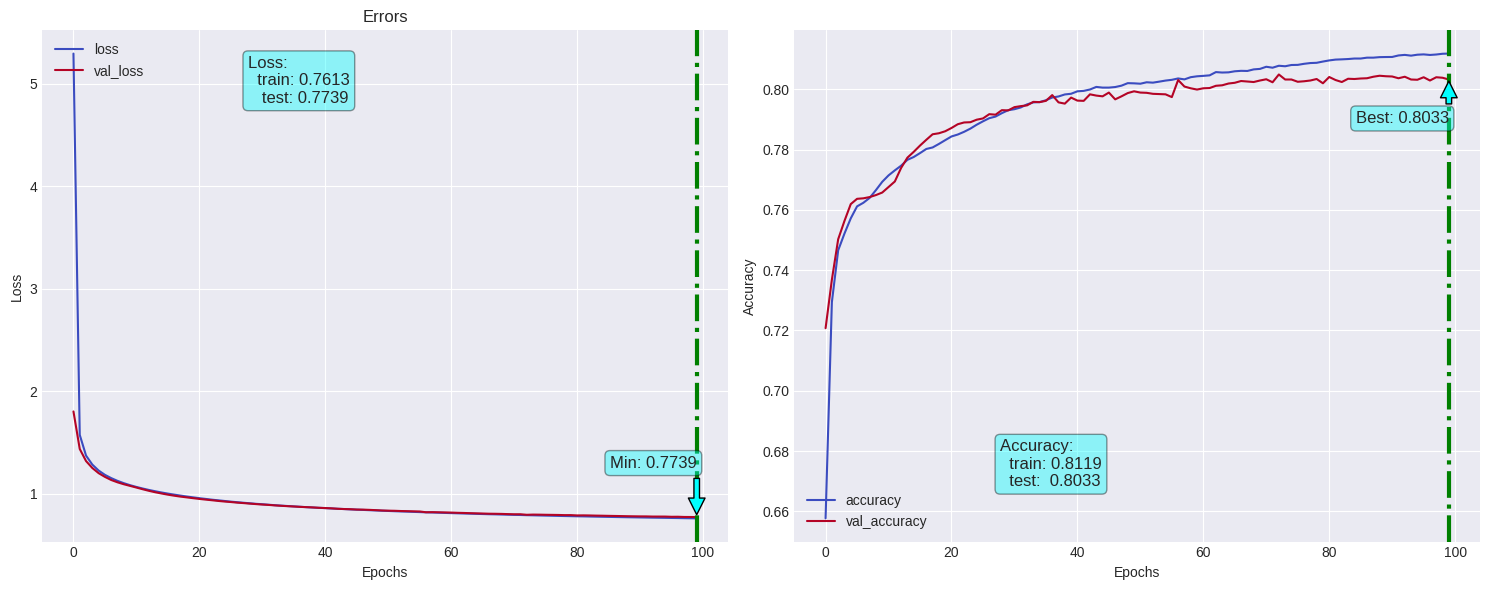

In [30]:
fn_plot_tf_hist(hist_df = hist_df)